Extracting EDF parameters from /Users/vedantmahendrakulkarni/IITR/eeg/Subject20_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /Users/vedantmahendrakulkarni/IITR/eeg/Subject06_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Extracting EDF parameters from /Users/vedantmahendrakulkarni/IITR/eeg/Subject04_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 84999  =      0.000 ...   169.998 secs...
Extracting EDF parameters from /Users/vedantmahendrakulkarni/IITR/eeg/Subject22_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Extracting EDF parameters from /Users/vedantmahendrakulkarni/IITR/eeg/Subject06_1.edf...

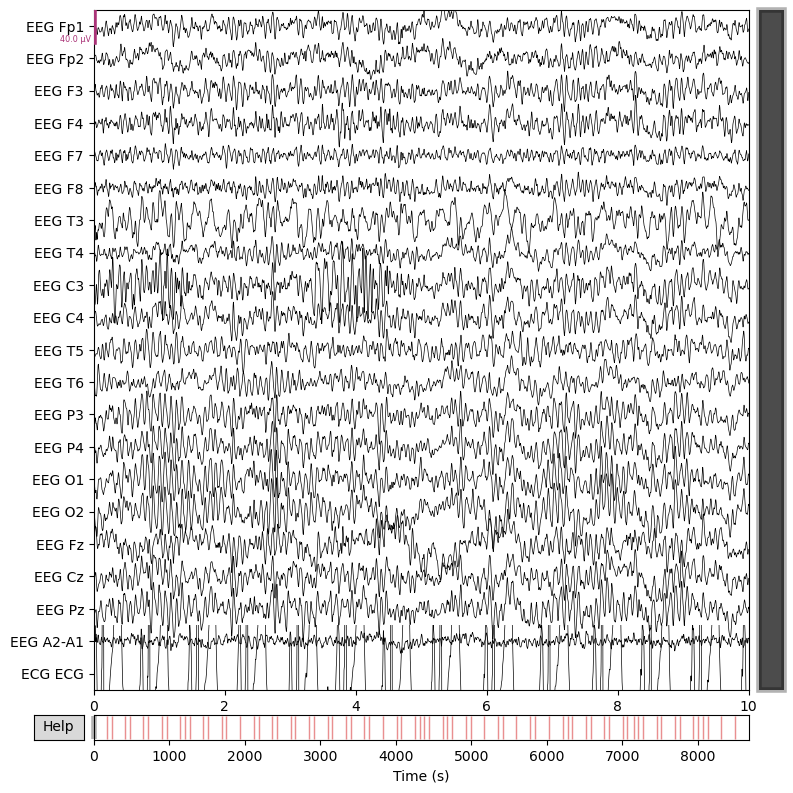

In [12]:
import mne
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Specify the path to your dataset directory (replace 'dataset_path' with your actual folder name)
dataset_path = './eeg/'

# List all EDF files in the dataset directory
file_list = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith('.edf')]

# Load each EDF file into a Raw object
raw_list = [mne.io.read_raw_edf(f, preload=True) for f in file_list]

# Concatenate all Raw objects into a single Raw object
if raw_list:
    raw = mne.concatenate_raws(raw_list)
    # Print basic info of the concatenated Raw object
    print(raw.info)
    # Plot the first few seconds of data to ensure it looks correct
    raw.plot(duration=10, n_channels=30)
else:
    print("No EDF files found in the specified directory.")


Effective window size : 4.096 (s)


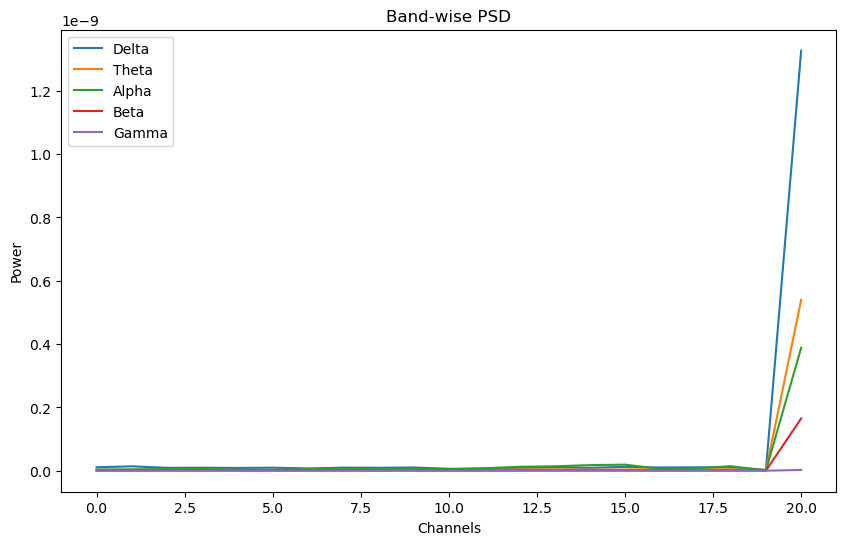

In [13]:
# Define frequency bands
frequency_bands = {
    'Delta': (1, 4),
    'Theta': (4, 8),
    'Alpha': (8, 12),
    'Beta': (12, 30),
    'Gamma': (30, 100)
}

# Compute PSD for the entire dataset
psd = raw.compute_psd(fmin=0.1, fmax=100, tmin=0, tmax=None, n_fft=2048, n_overlap=512)
psd_data = psd.get_data()
freqs = psd.freqs

# Calculate band-wise PSD
band_powers = {}
for band, (fmin, fmax) in frequency_bands.items():
    band_power = psd_data[:, (freqs >= fmin) & (freqs <= fmax)].mean(axis=1)
    band_powers[band] = band_power

    

# Plot the band-wise PSD
plt.figure(figsize=(10, 6))
for band in frequency_bands.keys():
    plt.plot(band_powers[band], label=band)
plt.xlabel('Channels')
plt.ylabel('Power')
plt.title('Band-wise PSD')
plt.legend()
plt.show()


No rest/task annotations found. Using manual segmentation.
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)


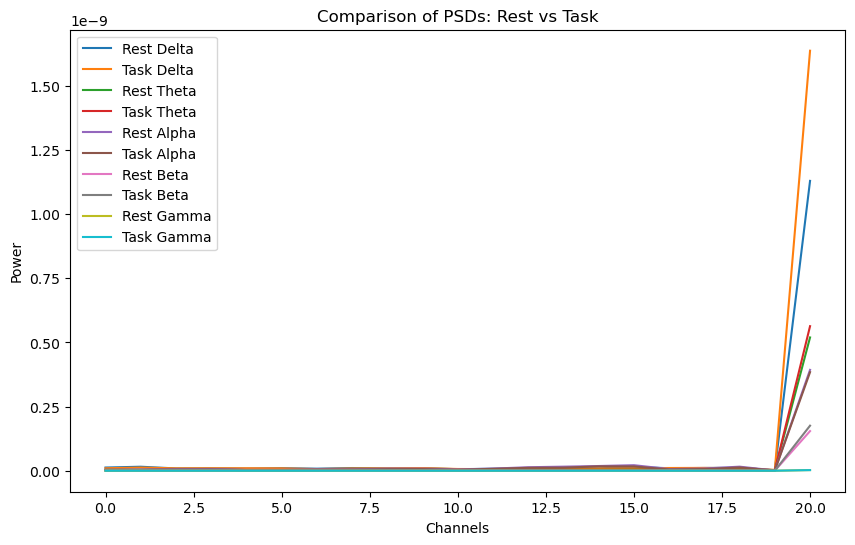

In [3]:
# Assuming rest and task states are separated by annotations
if raw.annotations:
    rest_annotations = [annot for annot in raw.annotations if 'rest' in annot['description'].lower()]
    task_annotations = [annot for annot in raw.annotations if 'task' in annot['description'].lower()]

    # If annotations are found, extract data based on them
    if rest_annotations and task_annotations:
        rest_raw = raw.copy().crop(tmin=rest_annotations[0]['onset'], tmax=rest_annotations[-1]['onset'] + rest_annotations[-1]['duration'])
        task_raw = raw.copy().crop(tmin=task_annotations[0]['onset'], tmax=task_annotations[-1]['onset'] + task_annotations[-1]['duration'])
    else:
        print("No rest/task annotations found. Using manual segmentation.")
        rest_raw = raw.copy().crop(tmin=0, tmax=raw.times[int(raw.n_times / 2)])
        task_raw = raw.copy().crop(tmin=raw.times[int(raw.n_times / 2)], tmax=raw.times[-1])
else:
    print("No annotations found. Using manual segmentation.")
    rest_raw = raw.copy().crop(tmin=0, tmax=raw.times[int(raw.n_times / 2)])
    task_raw = raw.copy().crop(tmin=raw.times[int(raw.n_times / 2)], tmax=raw.times[-1])

# Compute PSD for rest and task states
rest_psd = rest_raw.compute_psd(fmin=0.1, fmax=100, tmin=0, tmax=None, n_fft=2048, n_overlap=512)
rest_psd_data = rest_psd.get_data()
rest_freqs = rest_psd.freqs

task_psd = task_raw.compute_psd(fmin=0.1, fmax=100, tmin=0, tmax=None, n_fft=2048, n_overlap=512)
task_psd_data = task_psd.get_data()
task_freqs = task_psd.freqs

# Calculate band-wise PSD for rest and task states
rest_band_powers = {}
task_band_powers = {}
for band, (fmin, fmax) in frequency_bands.items():
    rest_band_powers[band] = rest_psd_data[:, (rest_freqs >= fmin) & (rest_freqs <= fmax)].mean(axis=1)
    task_band_powers[band] = task_psd_data[:, (task_freqs >= fmin) & (task_freqs <= fmax)].mean(axis=1)

# Compare PSDs of rest and task states
plt.figure(figsize=(10, 6))
for band in frequency_bands.keys():
    plt.plot(rest_band_powers[band], label=f'Rest {band}')
    plt.plot(task_band_powers[band], label=f'Task {band}')
plt.xlabel('Channels')
plt.ylabel('Power')
plt.title('Comparison of PSDs: Rest vs Task')
plt.legend()
plt.show()


In [15]:
# Combine PSD features into a single array
X_rest = np.array(list(rest_band_powers.values())).T
X_task = np.array(list(task_band_powers.values())).T
X = np.vstack([X_rest, X_task])
y = np.hstack([np.zeros(X_rest.shape[0]), np.ones(X_task.shape[0])])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape data for EEGNet
X_train_eegnet = X_train.reshape((X_train.shape[0], X_train.shape[1], 1, 1))
X_test_eegnet = X_test.reshape((X_test.shape[0], X_test.shape[1], 1, 1))

# Create and train EEGNet model
eegnet_model = Sequential([
    Conv2D(16, (1, X_train_eegnet.shape[2]), activation='relu', input_shape=X_train_eegnet.shape[1:]),
    MaxPooling2D((1, 1)),  # Adjusted MaxPooling2D to (1, 1)
    Dropout(0.5),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
eegnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
eegnet_model.fit(X_train_eegnet, y_train, epochs=50, batch_size=16, validation_split=0.2)

# Evaluate EEGNet model
y_pred_eegnet = (eegnet_model.predict(X_test_eegnet) > 0.5).astype(int)
accuracy_eegnet = accuracy_score(y_test, y_pred_eegnet)
precision_eegnet = precision_score(y_test, y_pred_eegnet)
recall_eegnet = recall_score(y_test, y_pred_eegnet)
f1_eegnet = f1_score(y_test, y_pred_eegnet)

print(f"EEGNet - Accuracy: {accuracy_eegnet}, Precision: {precision_eegnet}, Recall: {recall_eegnet}, F1-score: {f1_eegnet}")


Epoch 1/50
2/2 [==============================] - 0s 85ms/step - loss: 0.6931 - accuracy: 0.5769 - val_loss: 0.6932 - val_accuracy: 0.4286
Epoch 2/50
2/2 [==============================] - 0s 15ms/step - loss: 0.6935 - accuracy: 0.3846 - val_loss: 0.6931 - val_accuracy: 0.5714
Epoch 3/50
2/2 [==============================] - 0s 17ms/step - loss: 0.6931 - accuracy: 0.5385 - val_loss: 0.6932 - val_accuracy: 0.4286
Epoch 4/50
2/2 [==============================] - 0s 16ms/step - loss: 0.6932 - accuracy: 0.5385 - val_loss: 0.6933 - val_accuracy: 0.4286
Epoch 5/50
2/2 [==============================] - 0s 16ms/step - loss: 0.6938 - accuracy: 0.4231 - val_loss: 0.6934 - val_accuracy: 0.4286
Epoch 6/50
2/2 [==============================] - 0s 15ms/step - loss: 0.6935 - accuracy: 0.4615 - val_loss: 0.6934 - val_accuracy: 0.4286
Epoch 7/50
2/2 [==============================] - 0s 16ms/step - loss: 0.6929 - accuracy: 0.4615 - val_loss: 0.6935 - val_accuracy: 0.4286
Epoch 8/50
2/2 [===========

In [16]:
# Reshape data for TSCeption
X_train_tsception = X_train.reshape((X_train.shape[0], X_train.shape[1], 1, 1))
X_test_tsception = X_test.reshape((X_test.shape[0], X_test.shape[1], 1, 1))

# Create and train TSCeption model
tsception_model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=X_train_tsception.shape[1:], padding='same'),
    MaxPooling2D((1, 1)),  # Adjusted MaxPooling2D to (1, 1) or removed if not necessary
    Dropout(0.5),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
tsception_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
tsception_model.fit(X_train_tsception, y_train, epochs=50, batch_size=16, validation_split=0.2)

# Evaluate TSCeption model
y_pred_tsception = (tsception_model.predict(X_test_tsception) > 0.5).astype(int)
accuracy_tsception = accuracy_score(y_test, y_pred_tsception)
precision_tsception = precision_score(y_test, y_pred_tsception)
recall_tsception = recall_score(y_test, y_pred_tsception)
f1_tsception = f1_score(y_test, y_pred_tsception)

print(f"TSCeption - Accuracy: {accuracy_tsception}, Precision: {precision_tsception}, Recall: {recall_tsception}, F1-score: {f1_tsception}")


Epoch 1/50
2/2 [==============================] - 0s 90ms/step - loss: 0.6933 - accuracy: 0.4615 - val_loss: 0.6931 - val_accuracy: 0.5714
Epoch 2/50
2/2 [==============================] - 0s 16ms/step - loss: 0.6935 - accuracy: 0.3077 - val_loss: 0.6934 - val_accuracy: 0.4286
Epoch 3/50
2/2 [==============================] - 0s 17ms/step - loss: 0.6935 - accuracy: 0.3462 - val_loss: 0.6934 - val_accuracy: 0.4286
Epoch 4/50
2/2 [==============================] - 0s 18ms/step - loss: 0.6929 - accuracy: 0.5385 - val_loss: 0.6933 - val_accuracy: 0.4286
Epoch 5/50
2/2 [==============================] - 0s 19ms/step - loss: 0.6928 - accuracy: 0.5385 - val_loss: 0.6933 - val_accuracy: 0.4286
Epoch 6/50
2/2 [==============================] - 0s 18ms/step - loss: 0.6936 - accuracy: 0.4231 - val_loss: 0.6933 - val_accuracy: 0.4286
Epoch 7/50
2/2 [==============================] - 0s 19ms/step - loss: 0.6933 - accuracy: 0.5385 - val_loss: 0.6933 - val_accuracy: 0.4286
Epoch 8/50
2/2 [===========


"""
EEGNet and TSCeption are specifically designed for EEG signal classification. 

1. EEGNet: 
   - EEGNet is a compact, yet powerful model that is particularly well-suited for EEG data due to its ability to learn spatial-spectral-temporal features. 
   - It uses depthwise separable convolutions which reduce the number of parameters, making it efficient and faster to train. 

2. TSCeption:
   - TSCeption leverages temporal convolutional layers to capture temporal dependencies in EEG signals, which is critical for understanding cognitive states.
   - It uses multi-scale temporal convolutions to capture features at different temporal scales, which can improve the model's performance in tasks like cognitive state classification.

Both models are well-suited for the specific characteristics of EEG data, which include high dimensionality and temporal dependencies, and have shown effectiveness in similar EEG classification tasks.